<a href="https://colab.research.google.com/github/aknsntn/visualisation/blob/main/Text_Analysis_and_Visualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Пипы и импорты

In [ ]:
!pip install networkx==1.11
!pip install matplotlib==2.2.3 # эта ячейка решает судьбу колаба
# запустить -> перезапустить среду выполнения -> запустить все кроме нее

In [ ]:
!pip install razdel
!pip install pymorphy2
!pip install dostoevsky
!python -m dostoevsky download fasttext-social-network-model

In [ ]:
%%capture
!pip install pyLDAvis

In [ ]:
import requests
import string
import re
from wordcloud import WordCloud
from PIL import Image
from io import BytesIO
import numpy as np
from collections import Counter
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
import pymorphy2
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from razdel import tokenize
from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel
import networkx as nx
import gensim.corpora as corpora
from gensim.models import LdaMulticore, CoherenceModel
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
from gensim.models import LdaMulticore, CoherenceModel
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
import os
morph = pymorphy2.MorphAnalyzer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Сбор данных по VK API

In [ ]:
def filter_posts_to_string(rough_data):
  clean_data = []
  for i in rough_data:
    if i["text"] != '' and not "attachments" in i:
      if re.search("https:", i["text"]) == None:
        i["text"] = i["text"].translate(str.maketrans('', '', string.punctuation))
        clean_data.append(i["text"])
  pattern = re.compile(r"(\\n)+|\s+")
  clean_data = [re.sub('[^а-яА-ЯёЁa-zA-z]' , ' ' , row) for row in clean_data]
  

  return clean_data

In [ ]:
token = "9b41adc39b41adc39b41adc3099b3d7dcf99b419b41adc3f9d2ed8a60aa0af8b985fb47"
owner_id = -997314
domain = "club997314"
v = 5.92
offset = 0
count = 100
words = []
clean_posts = []
while len(clean_posts) < 500:
  response = requests.get("https://api.vk.com/method/wall.get", 
                          params={
                              "access_token" : token,
                              "owner_id": owner_id,
                              "domain": domain,
                              "v" : v,
                              "count" : count,
                              "offset": offset
                          })
  data = response.json()
  data = data['response']['items']
  clean_posts += filter_posts_to_string(data)
  for i in range(len(clean_posts)):
    words += clean_posts[i].split()
  offset += count

In [ ]:
len(words)

150817

# Обработка постов

In [ ]:
df = pd.DataFrame(clean_posts)

In [ ]:
stops = stopwords.words("russian") + ['здравствуйте', 'это', 'всё', 'ещё', 'мочь', 
                                      'год', 'день', 'очень', 'весь', 'добрый', 
                                      'сказать', 'стать', 'подсказать', 
                                      'пожалуйста', 'делать', 'изз', 'такой', 'каждый', 'такой']

In [ ]:
def clear(row):
  row = row.lower()
  row = re.sub('[^а-яА-ЯёЁa-zA-z]' , ' ' , row)
  token = row.split()
  lem = [morph.parse(word)[0].normal_form for word in token if not morph.parse(word)[0].normal_form in stops]

  prep_news = ' '.join(lem)

  return prep_news

In [ ]:
df['tokens'] = df[0].apply(lambda x: clear(x))
cl_words = list(map(clear, words))
cl_words = list(filter(None, cl_words))

In [ ]:
df.head()

,0,tokens
0,Здравствуйте Подскажите пожалуйста а изза недо...,недосып болеть сердце работать ночь наработа п...
1,подскажите пожалуйста можно ли принимать конко...,принимать конкор повышенный пульс
2,Дигоксин какого производителя лучше подскажит...,дигоксина производитель хороший
3,Добрый день Хотела узнать у вас по поводу приё...,хотеть узнать повод приём препарат терапевт на...
4,Чем отличается сердечный приступ от инфаркта,отличаться сердечный приступ инфаркт


In [ ]:
def get_tokens(sentence):
  return [_.text.strip() for _ in tokenize(sentence)]


df["tokens"] = df.tokens.apply(get_tokens)
df.head()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


,0,tokens
0,Здравствуйте Подскажите пожалуйста а изза недо...,"[недосып, болеть, сердце, работать, ночь, нара..."
1,подскажите пожалуйста можно ли принимать конко...,"[принимать, конкор, повышенный, пульс]"
2,Дигоксин какого производителя лучше подскажит...,"[дигоксина, производитель, хороший]"
3,Добрый день Хотела узнать у вас по поводу приё...,"[хотеть, узнать, повод, приём, препарат, терап..."
4,Чем отличается сердечный приступ от инфаркта,"[отличаться, сердечный, приступ, инфаркт]"


# Облако слов

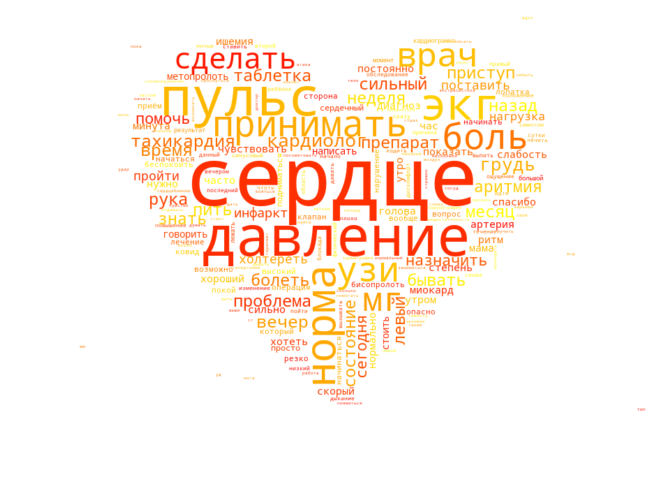

In [ ]:
words = dict(Counter(cl_words))
url = "https://www.pinclipart.com/picdir/middle/569-5696415_heart-disease-clipart.png"
response = requests.get(url)
cloud_mask = np.array(Image.open(BytesIO(response.content)))
wc = WordCloud(background_color="white", max_words=200, mask=cloud_mask, colormap="autumn")
wc.generate_from_frequencies(words)

plt.figure(figsize=(11, 11))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

# Анализ тональности


In [ ]:
tokenizer = RegexTokenizer()
model = FastTextSocialNetworkModel(tokenizer=tokenizer)

messages = clean_posts

In [ ]:
results = model.predict(messages, k=1)
sent = []

for message, sentiment in zip(messages, results):
    sent.append(list(sentiment.keys())[0])

df["sentiment"] = sent
df.rename(columns = {0: "text"})
df.head()

,0,tokens,sentiment
0,Здравствуйте Подскажите пожалуйста а изза недо...,"[недосып, болеть, сердце, работать, ночь, нара...",neutral
1,подскажите пожалуйста можно ли принимать конко...,"[принимать, конкор, повышенный, пульс]",neutral
2,Дигоксин какого производителя лучше подскажит...,"[дигоксина, производитель, хороший]",neutral
3,Добрый день Хотела узнать у вас по поводу приё...,"[хотеть, узнать, повод, приём, препарат, терап...",neutral
4,Чем отличается сердечный приступ от инфаркта,"[отличаться, сердечный, приступ, инфаркт]",positive


In [ ]:
df.sentiment.unique()

array(['neutral', 'positive', 'negative', 'speech', 'skip'], dtype=object)

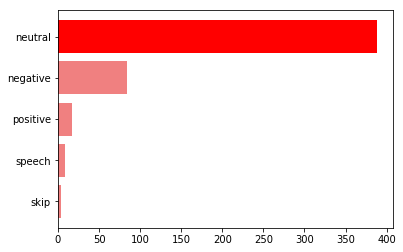

In [ ]:
vis = pd.DataFrame(df.sentiment.value_counts()).sort_values(by="sentiment")

colors = ["lightcoral" for _ in range(4)]+["red"]
plt.barh(y=vis.index, width=vis.sentiment, color=colors)
plt.show()

# Частотный анализ

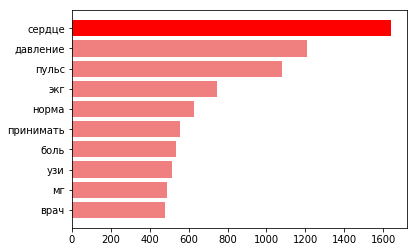

In [ ]:
res = pd.DataFrame(cl_words, columns=["terms"])
vis = pd.DataFrame(res.terms.value_counts()).sort_values(by="terms", ascending=False)[:10].sort_values(by="terms")
colors = ["lightcoral" for _ in range(9)]+["red"]
plt.barh(y=vis.index, width=vis.terms, color=colors)
plt.show()

In [ ]:
res.value_counts()

terms      
сердце         1638
давление       1210
пульс          1082
экг             746
норма           628
               ... 
узнавать          1
лекарстваон       1
ктонибыть         1
крым              1
aopa              1
Length: 3514, dtype: int64

# Графовая модель


In [ ]:
pairs = []
for doc in df.tokens.tolist():
  if doc:
    b = list((nltk.bigrams(doc)))
    if b:
      pairs.extend(b)
len(pairs)

11638

In [ ]:
pairs = [tuple(sorted(pair)) for pair in pairs]

In [ ]:
word_pairs = dict(Counter(pairs))
len(word_pairs)

10016


In [ ]:
word_pairs = [(pair[0], pair[1], val) for pair, val in word_pairs.items() if val > 5]
print(len(word_pairs))
word_pairs[:10]

59


[('болеть', 'сердце', 11),
 ('норма', 'пульс', 6),
 ('данный', 'момент', 7),
 ('грудь', 'тяжесть', 6),
 ('назад', 'неделя', 6),
 ('воздух', 'нехватка', 6),
 ('клапан', 'митральный', 10),
 ('месяц', 'назад', 6),
 ('давление', 'пульс', 29),
 ('сердце', 'узи', 29)]

In [ ]:
G = nx.Graph()
edges = word_pairs
edges[:10], len(edges)

([('болеть', 'сердце', 11),
  ('норма', 'пульс', 6),
  ('данный', 'момент', 7),
  ('грудь', 'тяжесть', 6),
  ('назад', 'неделя', 6),
  ('воздух', 'нехватка', 6),
  ('клапан', 'митральный', 10),
  ('месяц', 'назад', 6),
  ('давление', 'пульс', 29),
  ('сердце', 'узи', 29)],
 59)

/usr/local/lib/python3.7/dist-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/usr/local/lib/python3.7/dist-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/usr/local/lib/python3.7/dist-packages/networkx/drawing/nx_pylab.py:543: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if cb.is_string_like(edge_color) or len(edge_color) == 1:
/usr/local/lib/python3.7/dist-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(label):
/usr/local/lib/python3.7/dist-packages/networkx/drawing/nx_pylab.py:138: Matplot

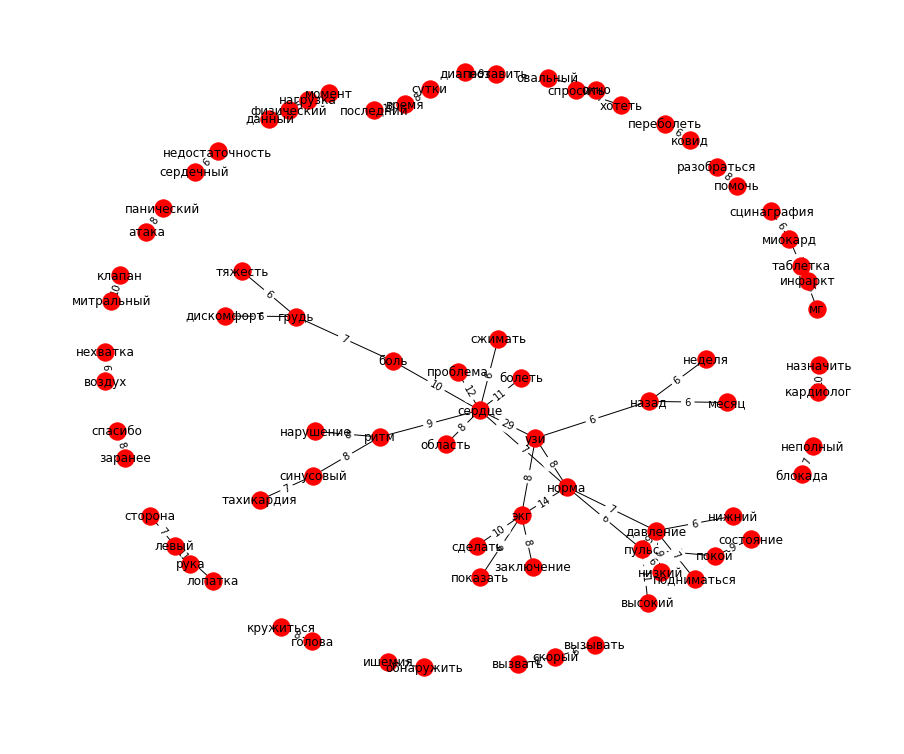

In [ ]:
plt.figure(figsize=(12,10))
G.add_weighted_edges_from(edges)
labels = nx.get_edge_attributes(G, "weight")
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()

In [ ]:
remove = [node for node, degree in dict(G.degree()).items() if degree < 2]
G.remove_nodes_from(remove)

In [ ]:
remove_edge = [pair for pair in G.edges() if pair[0] in remove and pair[1] in remove]
G.remove_edges_from(remove_edge)

In [ ]:
remove = [node for node, degree in dict(G.degree()).items() if degree < 1]
G.remove_nodes_from(remove)

In [ ]:
node_sizes = [deg*50 for node, deg in G.degree().items()]

/usr/local/lib/python3.7/dist-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/usr/local/lib/python3.7/dist-packages/networkx/drawing/nx_pylab.py:522: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not cb.is_string_like(edge_color) \
/usr/local/lib/python3.7/dist-packages/networkx/drawing/nx_pylab.py:526: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  for c in edge_color]):
/usr/local/lib/python3.7/dist-packages/networkx/drawing/nx_pylab.py:532: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  for c in edge_color]):
/usr/local/lib/python3.7/dist-packages/networkx/drawing/nx_pylab.py:724: MatplotlibDeprecationWarning: The is_string_like fun

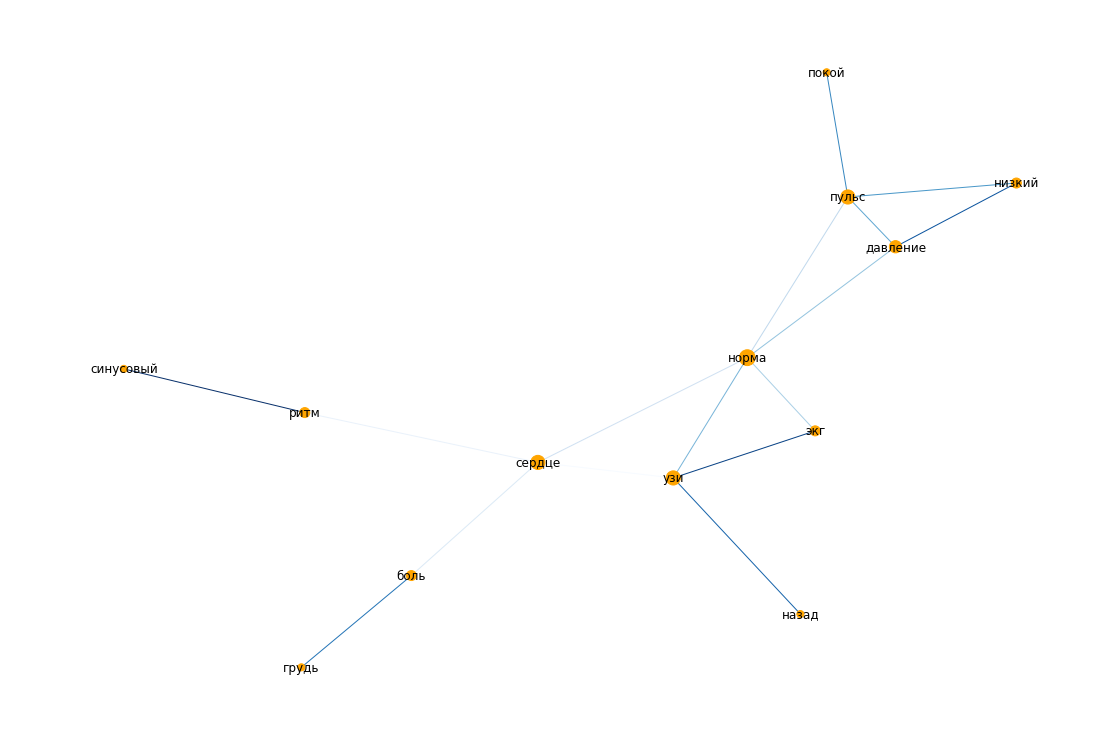

In [ ]:
plt.figure(figsize=(15,10))
pos = nx.layout.spring_layout(G)
edges, weights = zip(*nx.get_edge_attributes(G,'weight').items())
nx.draw(G, pos, node_color='orange', node_size=node_sizes, edgelist=G.edges(), edge_color=range(len(G.edges())), width=1.0, with_labels=True, edge_cmap=plt.cm.Blues)
plt.show()

# Тематическое моделирование

In [ ]:
id2word = corpora.Dictionary(df.tokens.tolist())
texts = df.tokens.tolist()
corpus = [id2word.doc2bow(text) for text in texts]

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
	Подсчет c_v когерентности для различного количества тем
	dictionary : Gensim словарь
	corpus : Gensim корпус
	texts : Список текста
	limit : Максимальное количество тем
	
	model_list : Список LDA моделей
	coherence_values :Когерентности, соответствующие модели LDA с количеством тем
    """
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model=LdaMulticore(corpus=corpus,id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values
	
# Вызовем функцию и посчитаем
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texts, start=2, limit=20, step=1)

100%|██████████| 18/18 [00:24<00:00,  1.38s/it]


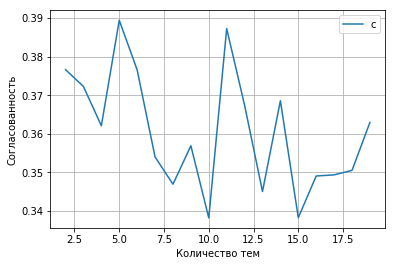

In [ ]:
limit=20; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Количество тем")
plt.ylabel("Согласованность")
plt.legend(("coherence_values"), loc='best')
plt.grid()
plt.show()

In [ ]:
n_topics = 5

In [ ]:
lda_model = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=n_topics)

In [ ]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.035724  0.035436       1        1  24.463850
1     -0.027162 -0.014618       2        1  22.869421
0     -0.029221 -0.032202       3        1  21.785394
2      0.053373 -0.035048       4        1  21.592296
4      0.038734  0.046432       5        1   9.289038, topic_info=          Term        Freq       Total Category  logprob  loglift
42          мг   49.000000   49.000000  Default  30.0000  30.0000
6       сердце  169.000000  169.000000  Default  29.0000  29.0000
52    давление  134.000000  134.000000  Default  28.0000  28.0000
10   принимать   56.000000   56.000000  Default  27.0000  27.0000
101      грудь   44.000000   44.000000  Default  26.0000  26.0000
..         ...         ...         ...      ...      ...      ...
477   нагрузка    2.788476   26.930595   Topic5  -6.0023   0.1086
11       пульс    3.476531  114.010832   Topic5  -5.7818  -1.1139
333    сделать    2.869067   45.510608   Topic5  -5.9739  -0.3876
241      месяц    2.647898   33.396310   Topic5  -6.0541  -0.1583
81         узи    2.601882   56.587009   Topic5  -6.0716  -0.7032

[408 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
1389      5  0.756632      александр
1390      5  0.756594  александрович
311       1  0.531529        аритмия
311       2  0.204434        аритмия
311       3  0.081774        аритмия
...     ...       ...            ...
398       5  0.068348            экг
1614      2  0.648965  экстросистола
375       4  0.955771    эликвиснуть
2722      1  0.856240            эос
654       1  0.645210           этап

[789 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 3, 5])

По данной визуализации мы сделали следующие выводы:


*   Первая тема про постановку диагноза и прохождение необходимых обследований
*   Вторая и третья темы пересекаются и относятся к описанию симптомов
*   Четвертая и пятая темы про препараты и лечение

Таким образом, мы решили сузить список до трех тем.



In [ ]:
n_topics2 = 3
lda_model2 = LdaMulticore(corpus=corpus, id2word=id2word, num_topics=n_topics2)

In [ ]:
pyLDAvis.enable_notebook()
LDAvis_prepared2 = pyLDAvis.gensim_models.prepare(lda_model2, corpus, id2word)
LDAvis_prepared2

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.035921  0.000856       1        1  38.017692
1      0.017155 -0.029070       2        1  34.983788
0      0.018766  0.028214       3        1  26.998520, topic_info=         Term        Freq       Total Category  logprob  loglift
52   давление  131.000000  131.000000  Default  30.0000  30.0000
23      норма   64.000000   64.000000  Default  29.0000  29.0000
6      сердце  172.000000  172.000000  Default  28.0000  28.0000
398       экг   85.000000   85.000000  Default  27.0000  27.0000
11      пульс  110.000000  110.000000  Default  26.0000  26.0000
..        ...         ...         ...      ...      ...      ...
333   сделать    8.601340   45.284962   Topic3  -5.9429  -0.3517
453      боль    8.844446   53.158352   Topic3  -5.9150  -0.4841
0      болеть    7.924767   36.623849   Topic3  -6.0248  -0.2213
420    пройти    7.513112   28.715244   Topic3  -6.0781  -0.0314
42         мг    7.711143   50.506416   Topic3  -6.0521  -0.5700

[267 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1100      1  0.851491        авурт
311       1  0.500892      аритмия
311       2  0.250446      аритмия
311       3  0.292187      аритмия
92        1  0.074097      артерия
...     ...       ...          ...
375       3  0.679790  эликвиснуть
1541      1  0.729364       эпизод
1541      2  0.182341       эпизод
1541      3  0.182341       эпизод
1113      1  0.852031          эфи

[428 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

Казалось бы, при сужении тем мы должны были прийти к более конкретным их определениям, однако теперь мы можем выделить следующие:

*   Первая тема -- симптомы и диагностика
*   Вторая тема -- о медикаментозном лечении
*   Третья тема -- скорее всего сформирована из записей людей,  которые просят совета на основе их самочувствия 